Import all required packages for this project at beginning

In [1]:
import pandas as pd
import numpy as np
import math
import os
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import operator
import seaborn as sns
from scipy import stats

Next Create all definitions and classes which will be used for this analysis.<br>
Explanations for each definition or class are included below.

In [2]:
# Function to calculate distance using the euclidean distance equation
def euclidean_distance(x1,x2):
    dist_vec=x1-x2
    ecld_dist=np.linalg.norm(dist_vec,1)
    return ecld_dist

In [3]:
# Function to calculate distance using the Manhattan distance equation
def manhattan_distance(x1,x2):
    dist_vec=x1-x2
    manhattan_dist=np.linalg.norm(dist_vec,2)
    return manhattan_dist

In [4]:
# Function to count number of TP, TN, FP, and FN
def eval_bins(label,prediction):
    true_positives = 0
    false_positives = 0
    true_negatives = 0
    false_negatives = 0
    for i in range(0,len(label)):
        if prediction[i]==1:
            if prediction[i]==label[i]:
                true_positives+=1
            else:
                false_positives+=1
        else:
            if prediction[i]==label[i]:
                true_negatives+=1
            else:
                false_negatives+=1
    return  true_positives,true_negatives,false_positives,false_negatives

In [5]:
# Definition to return the accuracy and generalization error of a vector prediction
def find_accuracy(label,prediction):
    #label =list vector of true labels
    #prediction=list vector of predicted labels
    tp,tn,fp,fn=eval_bins(label,prediction)
    #ratio of correctly predicted observations to total observations
    accuracy=(tp+tn)/(tp+tn+fp+fn)
    gen_error = 1-accuracy # Generalization error
    return accuracy,gen_error

In [6]:
# Definition to return the precision of a prediction
def find_precision(label,prediction):
    tp,_,fp,_=eval_bins(label,prediction)
    #how accurate it is with our true labels
    precision = tp/ (tp + fp)
    return precision

In [7]:
# Definition to return the recall for a prediction
def find_recall(label,prediction):
    tp,_,_,fn=eval_bins(label,prediction)
    #
    recall = tp / (tp + fn)
    return recall

In [8]:
# Definition to return the F1 score for a prediction
def f1_score(precision,recall):
    f1=2 / ((1 / precision) + (1 / recall))
    return f1

In [9]:
# Definition to return the confusion matrix for a prediction
def find_confusion_matrix(label,predicted):
    actual=np.array(label)
    predicted=np.array(predicted)
    K = len(np.unique(actual)) # Number of classes 
    cm=np.zeros((K,K))
    for i in range(len(actual)):
        cm[actual[i]][predicted[i]] += 1
    return cm 

In [10]:
# Definition to calculate and display the ROC curve for predicted vector
# This also returns the calculated Recall and Precision lists as they may be useful for other calculations
def generate_ROC_curve(label,prediction,score,threshIter):
    roc_x=[]
    roc_y=[]
    precision_list=[]
    recall_list=[]
    threshList = np.linspace(0,1,threshIter)
    
    count = 0
    num_in_cat = sum(label)
    num_not_in_cat = len(label) - sum(label)
    for threshold in threshList: # Go through each threshold in range
        FP=0
        TP=0
        TN=0
        FN=0
                    
        for id,item in enumerate(prediction):
            if score[id] > threshold:
                if ( (item == 1) and (label[id]==1) ):
                    TP += 1
                elif ( (item == 1) and (label[id]==0) ):
                    FP+=1
            elif score[id] < threshold:
                if ( (item == 0) and (label[id]==1) ):
                    FN+=1
                elif ( (item==0) and (label[id]==0) ):
                    TN+=1
        
        roc_x.append(FP / (TN+FP))
        roc_y.append(TP / (TP+FN))
        
        # Catch division by zero issues and replace manually with 0
        if ( int(TP)==0 and int(FP)==0):
            precision_list.append(0)
        else:
            precision_list.append(TP/(TP+FP))
        
        if ( int(TP)==0 and int(FN)==0):
            recall_list.append(0)
        else:
            recall_list.append(TP/(TP+FN))
            
    plt.plot(roc_x, roc_y, color='darkorange', linewidth=8, label=label) 
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.title('ROC Curve ')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate') 
    
    return threshList,precision_list,recall_list

In [11]:
# Returns the area under the ROC curve
def A_O_C(x,y): 
    aoc=np.trapz(y,x) # Calculate area under curve given by x vs y
    return aoc

In [12]:
# Calculate and display the precision recall curve
def Precision_recall_curve(threshList,precision_list,recall_list) :
    X=[]
    Y=[]
    
    plt.plot(threshList, precision_list, "b--",  linewidth=8, label="Precision") 
    plt.plot(threshList, recall_list, "g-",  linewidth=3, label="Recall") 
    plt.xlabel("Threshold")
    plt.legend(loc="lower right")
    plt.title('Precision-Recall Curve')

In [13]:
# Creates KNN Classifier Class
class kNN_classifier():
    
    # Initialization definition
    def __init__(self):
        pass
    
    # Definition stores relevant variables for use in other parts of class
    def fit(self,k,distance_f,threshold,training_features,training_labels,kwargs):
        # Note for this class kwargs is not used for anything, but is kept as it is good example for how to send in, and use arguments of that type
        
        self.training_features=training_features
        self.labels=training_labels
        self.k=k
        self.threshold = threshold
        self.distance_f=distance_f
        self.kwargs=kwargs
    
    # Definition Calculates nearest neighbors, and relevenat information from them
    def get_neighbors(self,test_instance):
        """
        get_neighors calculates a list of the k nearest neighbors
        of an instance 'test_instance'.
        The list neighbors contains 3-tuples with  
        (index, dist, label)
        where 
        index    is the index from the training_set, 
        dist     is the distance between the test_instance and the 
                 instance training_set[index]
        distance is a reference to a function used to calculate the 
                 distances
        """
        distances=[]
        for index in range(len(self.training_features)):
            dist = self.distance_f(test_instance, self.training_features[index])
            if (self.training_features[index] == test_instance).all(): # Do not include vectors matching ours
                continue
            distances.append((list(self.training_features[index]), dist, self.labels[index]))
        distances.sort(key=operator.itemgetter(1))
        kn=self.k
        neighbors = distances[:kn]
        return neighbors
    
    # Use results from nearest neighbors to determine class current feature vector
    def get_response(self,neighbors,weighted):
        pred_class = np.array([]) # numpy array holding all labels
        pred_score = np.array([])
        distance_score=np.array([])
        distance_score = []
        
        
        for x in range(len(neighbors)):
            result = neighbors[x][-1] # current label
            pred_class = np.append(pred_class, result) # append new label       
        unique, counts = np.unique(pred_class, return_counts=True)
        
        distance_score=np.asarray([1/float(x[1]) for x in neighbors])
        distance_score_sum = []
        
        unique_np = np.asarray(unique)
        for x in range(0,len(unique)):
            indices=np.argwhere(pred_class==unique[x])
            dsum = np.sum(distance_score[indices])
            distance_score_sum.append(dsum)
        indices_positive=np.argwhere(pred_class==1)
        
        confidence_score=len(indices_positive)/len(pred_class) # Calculate default confidence score
        
        if weighted:
            # Is below total score for our class (fails if len(distance_score_sum)==1)
            ds_positive_class=[distance_score_sum[x] for x in range(len(distance_score_sum)) if unique[x]==1]
            if len(ds_positive_class) == 0:
                ds_positive_class = 0
            confidence_score=float(ds_positive_class/sum(distance_score_sum)) # Replace if using weighted  
        
        if weighted:
            max_score_cat=unique[distance_score_sum==max(distance_score_sum)][0]
            
        else:
            max_score_cat=unique[counts==max(counts)][0]
            vote = int(max_score_cat)
        
        # Only set to True if confidence is above given threshold
        if ( (int(max_score_cat)==1) and (confidence_score>self.threshold)):
            vote = int(max_score_cat)
        else:
            vote = 0
        
        return vote,confidence_score
    
    # Main definition, calls other definitions and returns predictions for all given feature vectors
    def predict(self,test_features,weighted):
        predictions=[]
        self.test_result=[]
        for i in range(len(test_features)):
            test_instance=test_features[i][:]
            neighbors = self.get_neighbors(test_instance)
            vote,score=self.get_response(neighbors,weighted)
            predictions.append((test_features[i],vote,score))
        return predictions 

Below we import the dataset for testing.

In [14]:
file_name='winequality-white.csv'

# Read in data into pandas dataframe
df = pd.read_csv('winequality-white.csv', sep=';')

df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Below uses mask to reassign quality scores as either good (1) or bad (0).<br>
We thus turn this into a binary classification problem.

In [15]:
mask = df.quality <= 5
df.loc[mask, 'quality'] = 0
df.loc[~mask, 'quality'] = 1
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1


Below displays the statistical descriptions of all variables.

In [16]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,0.665169
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.471979
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,0.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,0.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,1.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,1.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,1.000000


Below we shuffle the rows to prevent the order in which data was entered affecting the results

In [17]:
df = df.sample(frac=1)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1915,7.2,0.360,0.36,5.7,0.038,26.0,98.0,0.99140,2.93,0.59,12.5,1
3271,6.5,0.320,0.34,5.7,0.044,27.0,91.0,0.99184,3.28,0.60,12.0,1
4609,6.0,0.615,0.04,0.8,0.032,8.0,50.0,0.99036,3.14,0.40,11.0,0
3887,7.2,0.240,0.36,2.0,0.029,21.0,63.0,0.99076,3.13,0.63,12.5,1
712,8.2,0.270,0.43,1.6,0.035,31.0,128.0,0.99160,3.10,0.50,12.3,1


The below section creates pair plots using Seaborn to identify the redundant features by using correlation scores and visual inspection for covariance.

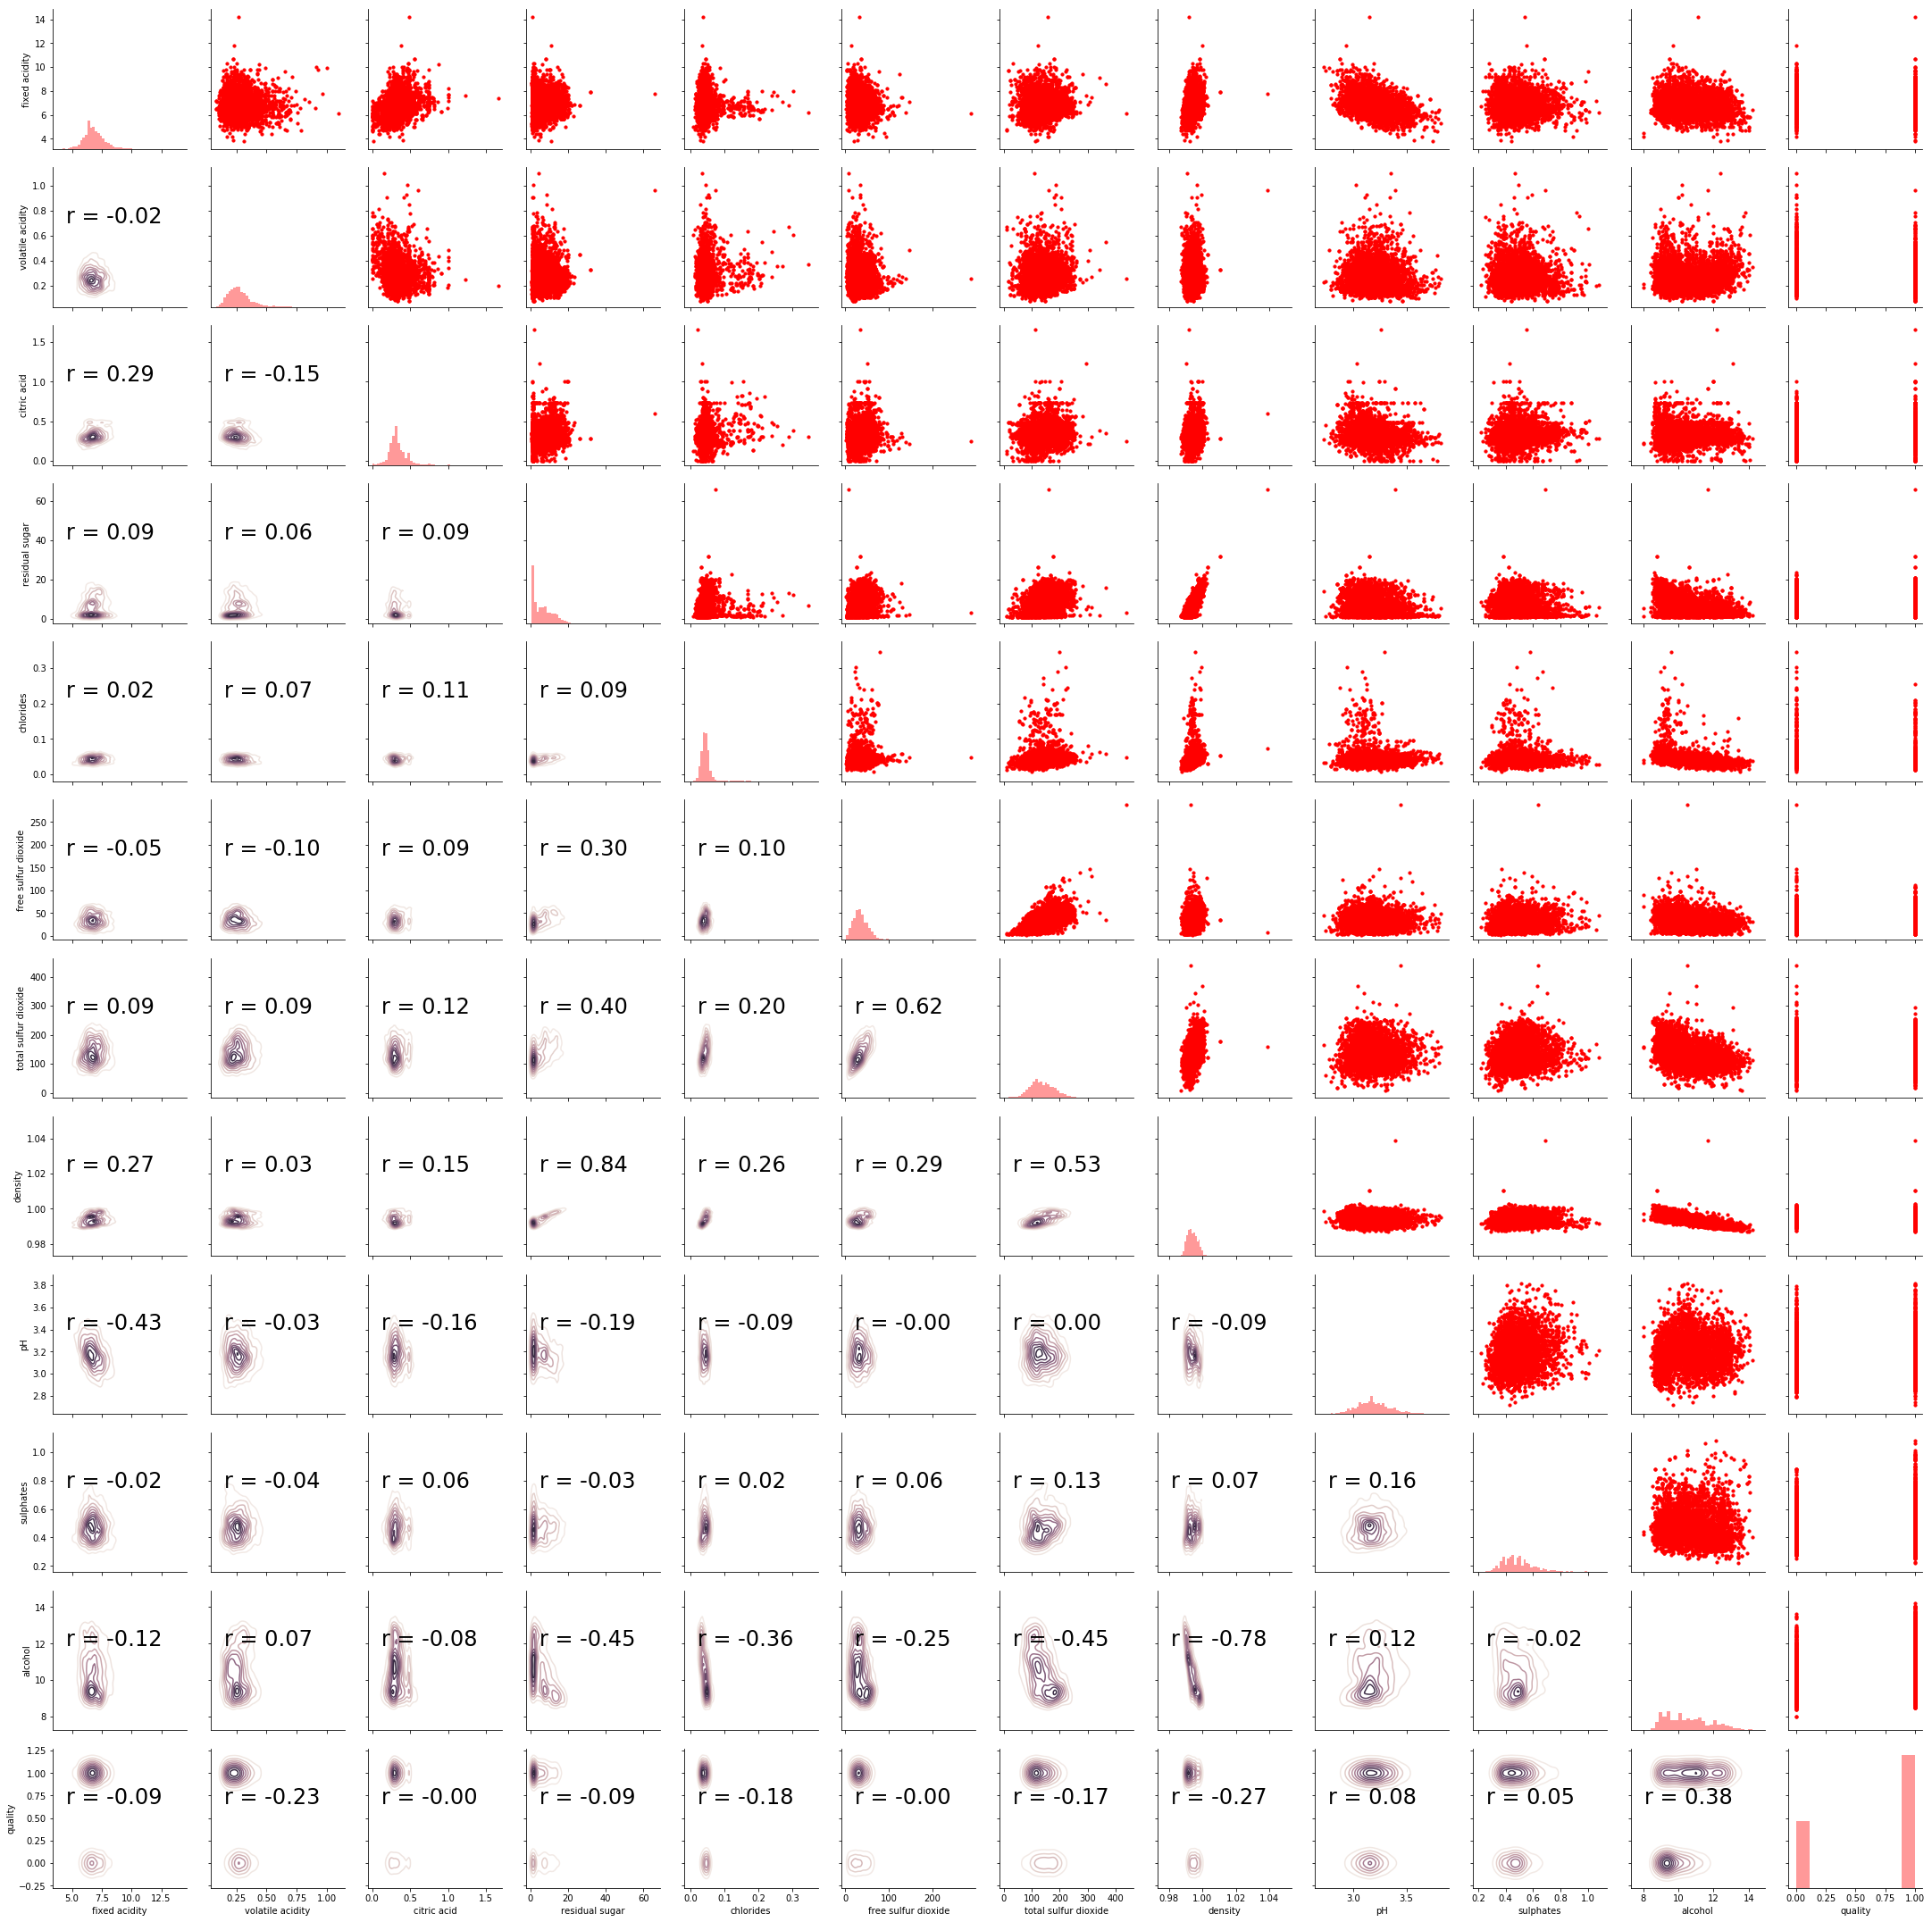

In [18]:
# Definition to calculate correlation coefficient
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .6), xycoords=ax.transAxes,
               size = 24)
    
cmap = sns.cubehelix_palette(light=1, dark = 0.1,
                             hue = 0.5, as_cmap=True)

sns.set_context(font_scale=2)

# Sets up pair grid
g = sns.PairGrid(df)

# Determine scatter plot to show in the upper triangle
g.map_upper(plt.scatter, s=10, color = 'red')

# Determine distribution to go on the diagonal
g.map_diag(sns.distplot, kde=False, color = 'red')

# Create density plots, with associated correlation coefficients, to go in the lower triangle
g.map_lower(sns.kdeplot, cmap = cmap)
g.map_lower(corrfunc);

Density seems to correlate quite well with many of the others (Will remove density)<br>
Chlorides seems to correlate moderately well with many of the others (will remove Chlorides)<br>
Residual sugar seems to have some correlations with other features (will remove residual sugar)<br>
Citric acid seems to correlate with fixed acidity (will remove citric acid)<br>
Free sulfur dioxide correlates with total sulfur dioxide (Will remove free sulfur dioxide)<br>
Fixed acidity seems to correlate with pH (Will remove fixed acidity)

Below we drop the features we have identified as redundant from the feature matrix

In [19]:
df = df.drop(columns=['density','chlorides','residual sugar','citric acid','free sulfur dioxide','fixed acidity'])

After removing recreate the pair plots to ensure no others need to be removed

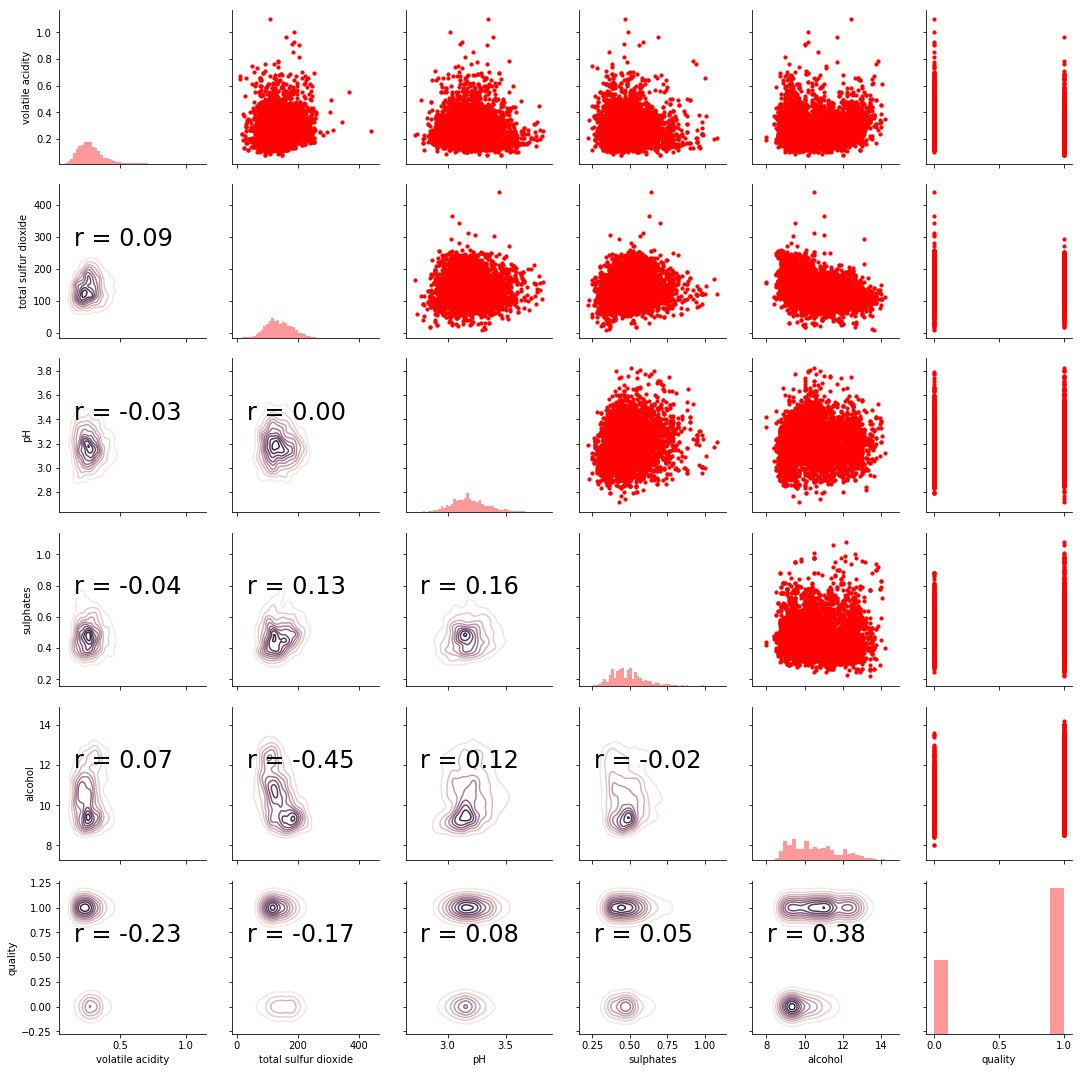

In [20]:
sns.set_context(font_scale=2)

# Pair grid set up
g = sns.PairGrid(df)

# Scatter plot on the upper triangle
g.map_upper(plt.scatter, s=10, color = 'red')

# Distribution on the diagonal
g.map_diag(sns.distplot, kde=False, color = 'red')

# Density Plot and Correlation coefficients on the lower triangle
g.map_lower(sns.kdeplot, cmap = cmap)
g.map_lower(corrfunc);

I will thus choose to keep the following variables in my model:<br>
Volatile Acidity<br>
Total Sulfur Dioxide<br>
pH<br>
Sulphates<br>
Alcohol<br>

Below we separate data into features and labels

In [21]:
# Target Vector (labels) is set as Y
Y = df["quality"]
Y = Y.values.astype(np.int)

# Features are separated in to X
X = df.drop(columns='quality') # Remove quality
X = X.values

# Check to make sure the separation makes sense
print(X.shape)
print(Y.shape)

(4898, 5)
(4898,)


The below definition splits the data into testing and training datasets

In [22]:
# X contain the features and Y contains the target vector
def partion(X,Y,t,random_state):
    np.random.seed(seed=random_state)
    num_rows = X.shape[0]
    test_size = int(t * num_rows)
    row_vec = list(range(0,num_rows))
    np.random.shuffle(row_vec) # randomize the ordering
    test_rows = row_vec[0 : test_size]
    
    train_rows = row_vec[test_size+1:len(row_vec)-1]
    
    # Now define x and y for training and testing
    X_test = X[test_rows,:]
    X_train = X[train_rows,:]
    Y_test = Y[test_rows]
    Y_train = Y[train_rows]
    
    return X_test,X_train,Y_test,Y_train

The below section creates the testing and training datasets

In [23]:
t = 0.20 # Use this percent of data for testing
random_state = 0 # Used to initialize the random number generator
X_test,X_train,Y_test,Y_train = partion(X,Y,t,random_state) # Separate into training and testing pieces

# Check dimensions below to ensure no mistakes have happened
print(X_test.shape)
print(X_train.shape)
print(len(Y_test))
print(len(Y_train))

(979, 5)
(3917, 5)
979
3917


This box provides the number of duplicate feature vectors in the dataset<br>
This may be useful to avoid overfitting by not considering enough input

In [24]:
num_total_rows = X_train.shape[0]
num_unique_rows = np.unique(X_train, axis=0).shape[0]
print("The number of duplicate rows is %i" %(num_total_rows - num_unique_rows))

The number of duplicate rows is 642


The below section calculates the predictions using KNN for unstandardized feature vectors

In [25]:
naive_classifier = kNN_classifier() # Call class
distance_f=euclidean_distance # Choose which distance function to send in
k=5 # Choose number of nearest neighbors to use
threshold = 0.5 # Threshold to use for categorizing data
kwargs={}
weighted=True # True will use inverse distances for weighting, False will not

# Get predictions for these feature vectors
naive_classifier.fit(k,distance_f,threshold,X_train,Y_train,kwargs) # Send relevant variables into our KNN class
naive_predictions=naive_classifier.predict(X_test,weighted)# Get out predictions as a list of lists
preds=[x[1] for x in naive_predictions] # Pull predictions out of output
conf_score=[x[-1] for x in naive_predictions] # Pull predictions out of output

# Calculate how accurate our prediction was using multiple metrics
accuracy,generalized_error=find_accuracy(Y_test,preds)
precision=find_precision(Y_test,preds)
recall=find_recall(Y_test,preds)
f1=f1_score(precision,recall)

print('The calculated accuracy for our unstandardized feature vectors is %0.2f' %accuracy)
print('The calculated precision for our unstandardized feature vectors is %0.2f' %precision)
print('The calculated recall for our unstandardized feature vectors is %0.2f' %recall)
print('The calculated f1 score for our unstandardized feature vectors is %0.2f' %f1)

The calculated accuracy for our unstandardized feature vectors is 0.66
The calculated precision for our unstandardized feature vectors is 0.74
The calculated recall for our unstandardized feature vectors is 0.75
The calculated f1 score for our unstandardized feature vectors is 0.74


Below we create the standardized feature and target vectors

In [26]:
mean=np.apply_along_axis(np.mean, 0,X_train)
SD=np.apply_along_axis(np.std,0,X_train)

X_train_standardized=X_train-mean.reshape(1,-1)
X_train_standardized=X_train/SD.reshape(1,-1)

X_test_standardized=X_test-mean.reshape(1,-1)
X_test_standardized=X_test/SD.reshape(1,-1)

The below section calculates the predictions using KNN for standardized feature vectors

In [27]:
naive_classifier = kNN_classifier() # Call class
distance_f=euclidean_distance # Choose which distance function to send in
k=5 # Choose number of nearest neighbors to use
threshold = 0.5 # Threshold to use for classifying
kwargs={}
weighted=True # True will use inverse distances for weighting, False will not

# Get predictions for these standardized feature vectors
naive_classifier.fit(k,distance_f,threshold,X_train_standardized,Y_train,kwargs)
naive_predictions_standardized=naive_classifier.predict(X_test_standardized,weighted)# this is a list of lists
preds_standardized=[x[1] for x in naive_predictions_standardized] #list comprehension
conf_score=[x[-1] for x in naive_predictions] # Pull predictions out of output

# Calculate how accurate our prediction was using multiple approaches
accuracy_standardized,generalized_error_standardized=find_accuracy(Y_test,preds_standardized)
precision_standardized=find_precision(Y_test,preds_standardized)
recall_standardized=find_recall(Y_test,preds_standardized)
f1_standardized=f1_score(precision_standardized,recall_standardized)

print('The calculated accuracy for our standardized feature vectors is %0.2f' %accuracy_standardized)
print('The calculated precision for our standardized feature vectors is %0.2f' %precision_standardized)
print('The calculated recall for our standardized feature vectors is %0.2f' %recall_standardized)
print('The calculated f1 score for our standardized feature vectors is %0.2f' %f1_standardized)

The calculated accuracy for our standardized feature vectors is 0.72
The calculated precision for our standardized feature vectors is 0.77
The calculated recall for our standardized feature vectors is 0.82
The calculated f1 score for our standardized feature vectors is 0.79


From the above results I believe that we should standardize our feature vectors. The accuracy and f1 score are both larger.<br>
These tests were performed with weighting by inverse distance turned off.<br>
All following calculations will use the standardized feature vectors.

From the above results I believe that we should use inverse distance for weighting. The accuracy and f1 scores are slightly improved, and when using larger number of nearest neighbors the benefit may increase even further.<br>
All following calculations will use inverse distances for weighting.

The below definition creates tupples holding the feature data and labels belonging to each fold of partitioned data

In [28]:
def split_data_folds(folds,data,labels,random_state):
    np.random.seed(seed=random_state)
    num_rows=data.shape[0]
    row_vec = list(range(0,num_rows))
    np.random.shuffle(row_vec) # randomize the ordering
    data=data[row_vec,:]
    labels=labels[row_vec]
    fold_size=int(data.shape[0]/folds) # Number of rows in each set
    fold_list=[]
    for i in range(folds):
        data_fold=data[i*fold_size:(i+1)*fold_size,:]
        labels_fold=labels[i*fold_size:(i+1)*fold_size]
        fold_list.append((data_fold,labels_fold))
    return fold_list   

The below definition performs s-fold cross validation

In [29]:
def s_fold_cross_validation(folds,model_args,data,labels,model,error_funcn):
    random_state=42
    dataset_split=split_data_folds(folds,data,labels,random_state)
    weighted=True
    kwargs={}
    error_per_fold=[]
    preds_per_fold=[]
    dict_per_fold={}
    keys=[]
    error_per_fold = []
    for i in range(folds):
        X_split_test=dataset_split[i][0]
        Y_split_test=dataset_split[i][-1]
        X_split_train=dataset_split[~i][0]
        Y_split_train=dataset_split[~i][-1]
        fit_function=model[0]
        predict_function=model[1]
        fit_function(*model_args,threshold,X_split_train,Y_split_train,kwargs)
        naive_predictions=predict_function(X_split_test,weighted)# this is a list of lists
        #list comprehension
        preds=[x[1] for x in naive_predictions]
        #now call get_accuracy
        if error_funcn==f1_score: # Others are needed to calculate f1 score
            accuracy=find_accuracy(Y_split_test,preds)
            precision=find_precision(Y_split_test,preds)
            recall=find_recall(Y_split_test,preds)
            error=f1_score(precision,recall)
        else:
            error=error_funcn(Y_split_test,preds)
        
        error_per_fold = np.append(error_per_fold,error)
        preds_per_fold.append((preds,Y_split_test))
        keys.append(i)
    
    values=[[p1, p2] for idx1, p1 in enumerate(preds_per_fold) for idx2, p2 in enumerate(error_per_fold) if idx1==idx2]
    dict_per_fold=dict(zip(keys, values))
    return dict_per_fold

The below section evaluates S-fold cross validation on the training dataset

In [31]:
k_list=[1,5,9,11] # list of number of neighbors to use
folds=3 # Number of partitions to split the data into
model_args={}
kwargs={}
threshold = 0.5 # Threshold for classification
weighted=True
# Below sends in Euclidean and Manhattan distances to S-fold cross validation definition to try
distance_dict={'euclidean_distance':euclidean_distance,'manhattan_distance':manhattan_distance}
error_funcn=find_precision # Choose error function to use

key=[k,distance_f] # Associating each type of distance function with a key
dict_temp={}
model_performance_list=np.empty((0,4)) # Initialize as empty list of same size as number of parameters to keep
count = 1
num_comb = len(k_list)*len(distance_dict)
for i in range(len(k_list)): # Goes over all different k-values
    for k,val in distance_dict.items(): # Goes over different distance functions
        print('Looking at combination %i of %i' %(count,num_comb))
        count+=1
        value=[k_list[i],val] # Holds number of nearest neighbors to try and distance function to use
        model_args = value
        model_name=kNN_classifier() # We will use the KNN class
        model=[model_name.fit,model_name.predict] # Send in kNN_classifier.fit and kNN_classifier.predict
        # Below calls s-fold cross validation definition and returns 
        dict_temp=s_fold_cross_validation(folds,model_args,X_train_standardized,Y_train,model,error_funcn)
        error_fold=[]
        for kk,jj in dict_temp.items():
            error_fold.append(jj[-1]) # Holds error for current distance function
        eavg=np.mean(np.asarray(error_fold)) # Holds average error for this choice of k
        std_error = np.std(np.asarray(error_fold))
        # Below holds (k-value,distance function,average, precision,std)
        model_performance_list=np.vstack((model_performance_list,[k_list[i],k,eavg,std_error]))

# Save full output of s-fold cross-validation to disk for use in report
df_s_fold = pd.DataFrame(model_performance_list,columns=['k-NN', 'Dist-Function', 'Precision', 'Std Deviation']) # Convert to pandas dataframe

print('\n')
print(df_s_fold)

Looking at combination 1 of 8
Looking at combination 2 of 8
Looking at combination 3 of 8
Looking at combination 4 of 8
Looking at combination 5 of 8
Looking at combination 6 of 8
Looking at combination 7 of 8
Looking at combination 8 of 8


  k-NN       Dist-Function           Precision          Std Deviation
0    1  euclidean_distance  0.7608611250365042   0.003361873915056931
1    1  manhattan_distance  0.7644428738119169  0.0010556973637614224
2    5  euclidean_distance   0.770733252102596   0.005616789375557974
3    5  manhattan_distance  0.7722687048561934   0.006027732802328018
4    9  euclidean_distance   0.775970009906367   0.009469922052146328
5    9  manhattan_distance   0.774541567272251   0.007922817076056106
6   11  euclidean_distance  0.7746659322368433   0.009265138531872916
7   11  manhattan_distance   0.773503709089406    0.01415720491725833


From the above results we have decided to use 9 nearest neighbors and the Euclidean distance function.<br>
The below calculations will use these values.

Below we use the above-found optimal k and distance type run the kNN classifier on the test dataset

In [32]:
knn_optimal=9 # Optimal number of nearest neighbors to use
model_args={}
kwargs={}
threshold = 0.5 # Threshold for classification
weighted=True
# Below sends in Euclidean and Manhattan distances to S-fold cross validation definition to try
distance_f=euclidean_distance

run_optimized=kNN_classifier() # Call class
# Get predictions for these feature vectors
run_optimized.fit(knn_optimal,distance_f,threshold,X_train_standardized,Y_train,kwargs)
run_optimized_predictions=run_optimized.predict(X_test_standardized,weighted)# this is a list of lists
preds_optimized=[x[1] for x in run_optimized_predictions] # Pull predictions from output list of lists
conf_score_optimized=[x[-1] for x in run_optimized_predictions] # Pull predictions out of output

# Calculate how accurate our prediction was using multiple approaches
accuracy_optimized,generalized_error_optimized=find_accuracy(Y_test,preds_optimized)
precision_optimized=find_precision(Y_test,preds_optimized)
recall_optimized=find_recall(Y_test,preds_optimized)
f1_optimized=f1_score(precision_standardized,recall_optimized)

# Convert predictions and test to integers (Necessary for below function to work correctly)
preds_optimized = [int(i) for i in preds_optimized]
Y_test = [int(i) for i in Y_test]
# Create confusion matrix
cm_optimized=find_confusion_matrix(Y_test,preds_optimized)

print('The calculated accuracy for our test is %0.2f' %accuracy_optimized)
print('The calculated precision for our test is %0.2f' %precision_optimized)
print('The calculated recall for our test is %0.2f' %recall_optimized)
print('The calculated f1 score for our test is %0.2f' %f1_optimized)
print('The Confusion Matrix for the optimized parameters is given below:')
print(cm_optimized)

The calculated accuracy for our test is 0.74
The calculated precision for our test is 0.78
The calculated recall for our test is 0.84
The calculated f1 score for our test is 0.80
The Confusion Matrix for the optimized parameters is given below:
[[175. 152.]
 [106. 546.]]


Below we create the definition to calculate our confidence interval

In [33]:
def confid_interval(error,pred_vec,actual_vec,percentile):
    if percentile==90:
        z = 1.645
    elif percentile==95:
        z = 1.96
    elif percentile==99:
        z = 2.58
    else:
        print('Not working correctly as the z-score for this percentile not added yet')
        
    num_rows = len(pred_vec)
    match = np.zeros(num_rows)
    for i in range(0,num_rows):
        if pred_vec[i]==actual_vec[i]:
            match[i] = 1
        else:
            match[i] = 0
    # match contains all matching (1) vs not matching (0)
    num_match = np.sum(match)
    num_notMatch = num_rows - num_match
    std_match = np.std(match)
    
    margin = z * (std_match/np.sqrt(num_rows))
    lower_bound = error - margin
    upper_bound = error + margin
    
    print('Within %i percent the generalization error is between %.2f and %.2f' %(percentile,lower_bound,upper_bound) )

Below we generate the confidence interval on the generalization error from the optimized model

In [34]:
percentile = 95 # Desired confidence percentile

confid_interval(generalized_error_optimized,preds_optimized,Y_test,percentile)

Within 95 percent the generalization error is between 0.24 and 0.29


Below we plot the ROC curve for our optimized model

[0.14400254079670982, 0.1918186441909467, 0.0, 0.21055491691921827, 0.7695530726256978, 0.5370825818440178, 0.3555099247091025, 1.0, 0.0, 0.08215279332288686, 0.46850393700787357, 0.4249498896556648, 0.15144342783600429, 0.9551475957025032, 0.2073831130140419, 0.8944971780866408, 1.0, 0.3544101028545977, 0.6030272127099996, 0.6797184337879452, 0.5652442110653904, 1.0, 0.31284919453847354, 0.18399298174579065, 0.7449635376777317, 1.0, 0.5576278595366456, 0.769301765924427, 1.0, 0.12873510706461794, 0.8360502839904094, 0.5901670272915401, 1.0, 1.0, 0.44164056312989086, 0.1948246257325434, 1.0, 0.4663833473749445, 0.14537071353639924, 0.07811060449835547, 0.6669553997073437, 0.5491423872689777, 0.8115833340014664, 0.8258064516129032, 0.5549132947976877, 0.7074756920104776, 0.0, 0.621522536122493, 0.5324873465236236, 0.4469582704876823, 0.8019257221458052, 1.0, 0.0, 0.4773690305012279, 0.6110941119902082, 0.7929810376099644, 0.821742698234203, 1.0, 0.47461928934010206, 1.0, 1.0, 1.0, 0.558

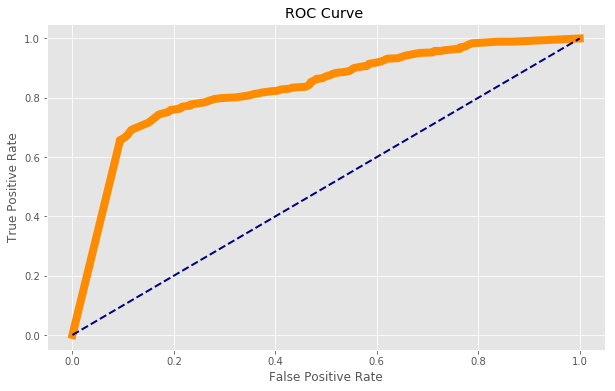

In [35]:
threshIter = 100 # Number of different thresholds to use for creating the ROC curve
plt.style.use('ggplot')
weighted = True
kwargs = {}
distance_f=euclidean_distance # Choose which distance function to send in
fig=plt.figure(figsize=(10,6))
print(conf_score)
# generate_ROC_curve(k,distance_f,threshIter,X_train,Y_train,weighted,kwargs)
threshList,precision_list,recall_list=generate_ROC_curve(Y_test,preds_optimized,conf_score_optimized,threshIter)
plt.show()

Below we create a Precision-Recall Curve for our optimized model

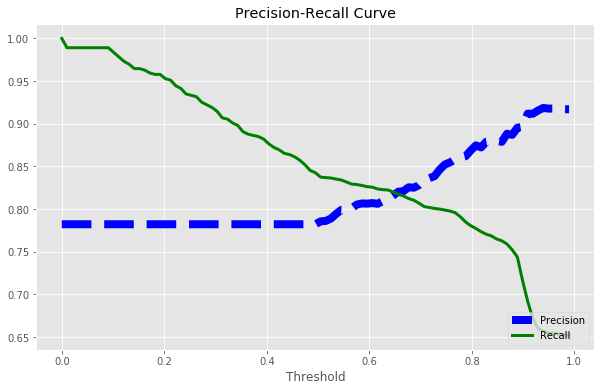

In [36]:
plt.style.use('ggplot')
fig=plt.figure(figsize=(10,6))

# Below removes last entry, corresponding to threshold = 1, where there are no TP at all
threshList = threshList[:(threshIter-1)]
precision_list = precision_list[:(threshIter-1)]
recall_list = recall_list[:(threshIter-1)]

# Below creates the Precision-Recall Curve
Precision_recall_curve(threshList,precision_list,recall_list)
plt.show()